# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

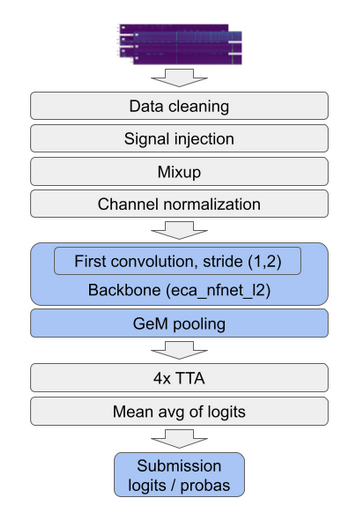

In [1]:
# !pip install timm
# !pip install albumentations
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

In [2]:
import os
import random
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision.transforms as transforms
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import timm
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb
from matplotlib import pyplot as plt

In [3]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'batch_size': 32,
    'epochs': 50,
    'num_folds': 10
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '2000_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [6]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   string
 1   target          2000 non-null   int32 
 2   image_filepath  2000 non-null   string
dtypes: int32(1), string(2)
memory usage: 39.2 KB


Split the data into 70% train and 30% test:

In [38]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [8]:
def resize_image(image):
    # img = cv2.imread('your_image.jpg')
    return cv2.resize(image, dsize=(config['image_size'], config['image_size']), interpolation=cv2.INTER_CUBIC)

def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()

In [41]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform
        # self.transform = None

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = np.load(image_filepath).astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
            
        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()

        return image, label

# Image Augmentation

In [10]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

In [11]:
def mixup(x, y, alpha=1.0, use_cuda=True):

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Loss and ROC Monitoring

In [12]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
def use_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5

# Weight Random Sampler

In [13]:
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]

    return WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# Train and Validation Dataloaders

In [14]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform=get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform=get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size=config['batch_size'],
        # shuffle=True,
        # num_workers=config['num_workers'],
        sampler = sampler,
        pin_memory=True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return train_loader, valid_loader

# Model

In [15]:
class EcaNFNet(nn.Module):
    def __init__(self, model_name=config['model'], output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=input_channels)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, output_features, bias=True)    
    
    def forward(self, x):
        x = self.model(x)
        return x

# Sharpness Aware Minimisation (SAM) Optimiser

In [16]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm



# Initialise Model, Loss Function, Optimizer and Scheduler

In [17]:
model = EcaNFNet()
model = model.to(config['device'])
criterion = nn.BCEWithLogitsLoss().to(config['device'])
base_optimizer = AdamP
optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

# K-Fold CV

In [18]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(enumerate(train_loader), total=len(train_loader))
       
    for i, (images, target, images_indices) in stream:
        images = images.to(config['device'])
        target = target.to(config['device']).float().view(-1, 1)
        images, targets_a, targets_b, lam = mixup(images, target.view(-1, 1))

        optimizer.zero_grad()

        output = model(images)

        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward(retain_graph = True)

        optimizer.first_step(zero_grad=False)
        
        mixup_criterion(criterion, model(images), targets_a, targets_b, lam).backward()
        optimizer.second_step(zero_grad=False)
        
        roc_score = use_roc_score(output, target)

        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('ROC', roc_score)

        wandb.log({'Train Epoch': epoch, 'Train loss': loss.item(), 'Train ROC': roc_score})

        stream.set_description('Epoch: {epoch}. Train. {metric_monitor}'
                               .format(epoch=epoch, metric_monitor=metric_monitor))

    scheduler.step()

In [19]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(enumerate(val_loader), total=len(val_loader))
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for i, (images, target, image_indices) in stream:
            images = images.to(config['device'], non_blocking=True)
            target = target.to(config['device'], non_blocking=True).float().view(-1, 1)

            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)

            wandb.log({"Valid Epoch": epoch, "Valid loss": loss.item(), "Valid ROC":roc_score})

            stream.set_description("Epoch: {epoch}. Validation. {metric_monitor}"
                                   .format(epoch=epoch, metric_monitor=metric_monitor))
            
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

# W&B Initialisation for K-Fold CV

**W&B API key**: 47b00b0f6291346fe94ab4a6dceca03a809fbf4a

# Training loop

Create directory to save models for this run:

In [20]:
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)
os.mkdir(models_dir)

Execute the training loop:

In [21]:
best_roc = -np.inf
best_epoch = -np.inf
best_model_name = None
kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])

for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df, train_df['target'])):
    run = wandb.init(
            project='eca-NFNet-Mixup',
            config=config,
            group='ECA-NFNet',
            job_type='train',
            name=f"{current_datetime} - fold {fold}")

    print(f"{'='*40} Fold: {fold} {'='*40}")

    train_data = train_df.iloc[trn_idx]
    valid_data = train_df.iloc[val_idx]

    sampler = get_sampler(train_data)

    train_loader, valid_loader = get_loaders(train_data, valid_data, sampler)

    for epoch in range(1, config['epochs'] + 1):
        train(train_loader, model, criterion, optimizer, epoch, scheduler)
        valid_predictions, valid_targets = validate(valid_loader, model, criterion, epoch)

        valid_roc_auc = round(roc_auc_score(valid_targets, valid_predictions), 3)

        torch.save(model.state_dict(), os.path.join(models_dir, f"{config['model']}_{epoch}_epoch_{valid_roc_auc}_roc_auc.pth"))

        if valid_roc_auc > best_roc:
            best_roc = valid_roc_auc
            best_epoch = epoch
            best_model_name = f"{config['model']}_{epoch}_epoch_{valid_roc_auc}_roc_auc.pth"

    print(f'Best ROC-AUC in fold {fold} was {best_roc:.4f}')
    print(f'Final ROC-AUC in fold {fold} was {valid_roc_auc:.4f}')
    print(f'Best model name in fold {fold} was {best_model_name}')

wandb: Currently logged in as: mllm. Use `wandb login --relogin` to force relogin


======================================== Fold: 0 ========================================


Epoch: 1. Train. Loss: 0.698 | ROC: 0.512: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]
D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\venv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch: 1. Validation. Loss: 0.688 | ROC: 0.494: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]
Epoch: 2. Train. Loss: 0.692 | ROC: 0.521: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]
Epoch: 2. Validation. Loss: 0.697 | ROC: 0.481: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]
Epoch: 3. Train. Loss: 0.694 

Best ROC-AUC in fold 0 was 0.6560
Final ROC-AUC in fold 0 was 0.5820
Best model name in fold 0 was eca_nfnet_l0_40_epoch_0.656_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,█▃▄▅▄▃▆▅▃▄▄▃▅▅▅▃▅▂▆▃▆▃▆▇▄▄▆▅▂▆▁▅▇▆▆▄▇▇▃▇
Train loss,▂▆▇▅▅▅▄▅▆▅▆▄▃▃▃▆▅▆▆▆▆▆█▅▅▂▅▄▅▅█▄▄▃▄▅▂▂▇▁
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▄▁▄▄▄▄▄▄▄▄▄▄▁▄▄▄▄▄▄▄▆▄▄▅▄▄▄▄▄▄▄█▄▄▆▄▄▄▄█
Valid loss,▅▅▃▃▄▁▂▄▄▄▅▄▄▃▄▂▄▄▄▄▃▂▃▄▃▃▄▄▁▅▄▂█▆▃▆▄▃▃▃
Train Epoch,50
Train ROC,0.45312
Train loss,0.70379
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 1 ========================================


Epoch: 1. Train. Loss: 0.685 | ROC: 0.544: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 1. Validation. Loss: 0.647 | ROC: 0.556: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]
Epoch: 2. Train. Loss: 0.682 | ROC: 0.543: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 2. Validation. Loss: 0.646 | ROC: 0.561: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
Epoch: 3. Train. Loss: 0.681 | ROC: 0.572: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 3. Validation. Loss: 0.651 | ROC: 0.549: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]
Epoch: 4. Train. Loss: 0.686 | ROC: 0.538: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 4. Validation. Loss: 0.647 | ROC: 0.568: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
Epoch: 5. Train. Loss: 0.688 | ROC: 0.528: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 5. Validation. Loss: 0.644 | ROC: 0.552: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
Epoch: 6. Train. Loss: 0.685 | ROC: 0.543: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 1 was 0.7490
Final ROC-AUC in fold 1 was 0.6230
Best model name in fold 1 was eca_nfnet_l0_35_epoch_0.749_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▅▇▆▆▄▇▃▅▅▄▄▅█▄▁▇▅▅▆▅█▄▄▆▇▄▆▄▄▆▇▅▇▂▆▅▂▇▇▅
Train loss,▅▄▅▄▆▄▇▆▅▆▅▄▄▅█▄▅▂▃▇▄▅▅▇▄▂▃▂▇▂▃▇▅▁▂▄█▂▃█
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁▇▁▁▁▁▁▁▁▆▁▁▇▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▆
Valid loss,▅▃▄▆▅▆▂▅▂▄▆▃▃▄▅▅▄▄▅▃▂▂▄▄▆▂▃▄▂▅▇▁▅▁▁▆▂▅█▃
Train Epoch,50
Train ROC,0.43333
Train loss,0.61256
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 2 ========================================


Epoch: 1. Train. Loss: 0.651 | ROC: 0.608: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
Epoch: 1. Validation. Loss: 0.539 | ROC: 0.586: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]
Epoch: 2. Train. Loss: 0.655 | ROC: 0.579: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 2. Validation. Loss: 0.528 | ROC: 0.554: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
Epoch: 3. Train. Loss: 0.664 | ROC: 0.575: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 3. Validation. Loss: 0.499 | ROC: 0.567: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]
Epoch: 4. Train. Loss: 0.652 | ROC: 0.597: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 4. Validation. Loss: 0.511 | ROC: 0.575: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
Epoch: 5. Train. Loss: 0.643 | ROC: 0.610: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 5. Validation. Loss: 0.480 | ROC: 0.582: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
Epoch: 6. Train. Loss: 0.638 | ROC: 0.623: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 2 was 0.8600
Final ROC-AUC in fold 2 was 0.7930
Best model name in fold 2 was eca_nfnet_l0_3_epoch_0.86_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▅▆▆▂▂▃█▆▅▄▅▇▆▅▆▃▇▅▃▅▃▄▅▆▇▇▄▆▄▆▆▄▄▄▃▁█▂▂▂
Train loss,▅▅▄▆█▅▃▅▅▄▅▃▆▆▇▅▅▅▇▇█▇▇▄▂▃▇▅▅▆▄▇▆▆▂▂▁▃▆▆
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁▆▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁▇▁▁▁▁▁▁▁▄▁▁▅▁▁▁▁▅
Valid loss,▇▄▄▄▅▆▃▄▅▅▄▃▄▃▄▄▆▃▅█▄▄▂▅▄▂▅▇▄▅▆█▆▁▆▇▂▆█▆
Train Epoch,50
Train ROC,0.81667
Train loss,0.64481
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 3 ========================================


Epoch: 1. Train. Loss: 0.594 | ROC: 0.648: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
Epoch: 1. Validation. Loss: 0.323 | ROC: 0.587: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]
Epoch: 2. Train. Loss: 0.612 | ROC: 0.698: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 2. Validation. Loss: 0.323 | ROC: 0.585: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]
Epoch: 3. Train. Loss: 0.583 | ROC: 0.659: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 3. Validation. Loss: 0.325 | ROC: 0.586: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]
Epoch: 4. Train. Loss: 0.590 | ROC: 0.655: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 4. Validation. Loss: 0.324 | ROC: 0.577: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]
Epoch: 5. Train. Loss: 0.586 | ROC: 0.714: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 5. Validation. Loss: 0.331 | ROC: 0.571: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]
Epoch: 6. Train. Loss: 0.579 | ROC: 0.682: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 3 was 0.9610
Final ROC-AUC in fold 3 was 0.8580
Best model name in fold 3 was eca_nfnet_l0_1_epoch_0.961_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▆▃▇▃▅▇▂▃▅▄▄▆▁▄▄▃▁▂▆▅▆▄▄▄▇█▇▇▆█▄▂▃▂▇▄▆▅▂▅
Train loss,▂▅▄▄▁▄▅▂█▇▃▇▆▇▆▆▄▇▇▇▅▆▇▃▅▃▄▅▆▄▄▆▃▇▅▄▆▅▆▅
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁▅▁▁▅▁▁▁▁▁▁▁▄▁▁▆▁▁▁▁▁▁▁▆▁▁▆▁▁▁▁▅
Valid loss,▃▃▃▂▃▄▄▄▆▆▅▆▆▃▅▃▄▅▃▄▇▅▁█▃▃▃▄▅▃▅▇▆▄▆▇▂▄▃▆
Train Epoch,50
Train ROC,0.65625
Train loss,0.60496
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 4 ========================================


Epoch: 1. Train. Loss: 0.600 | ROC: 0.666: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
Epoch: 1. Validation. Loss: 0.378 | ROC: 0.598: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]
Epoch: 2. Train. Loss: 0.573 | ROC: 0.654: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 2. Validation. Loss: 0.312 | ROC: 0.597: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
Epoch: 3. Train. Loss: 0.572 | ROC: 0.681: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 3. Validation. Loss: 0.370 | ROC: 0.587: 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]
Epoch: 4. Train. Loss: 0.586 | ROC: 0.674: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 4. Validation. Loss: 0.314 | ROC: 0.593: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]
Epoch: 5. Train. Loss: 0.560 | ROC: 0.656: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 5. Validation. Loss: 0.315 | ROC: 0.599: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]
Epoch: 6. Train. Loss: 0.601 | ROC: 0.676: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 4 was 0.9790
Final ROC-AUC in fold 4 was 0.9470
Best model name in fold 4 was eca_nfnet_l0_17_epoch_0.979_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▄▅▆▄▅▅▄▄▃▇▅▄▃▇▅▂▆▄▄█▇▃▄▁▆▅▅▇▆▇▆████▆▃▇▆▇
Train loss,▅▆▅▆▆▇▇▃▆▅▅█▃▆▆▄▆▆▆▃▃▄▁▂▇▆▆▄▄▄▆▄▄▂▂▆▆▄▆▄
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁█
Valid loss,▃▃▃▃▂▂▄▁▂▂▂▃▂▃▅▁▁▅▁▂▃▃▅▃▃▄▁▃▃▃▅▃▄█▃▆▄▁▃▂
Train Epoch,50
Train ROC,0.93333
Train loss,0.41096
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 5 ========================================


Epoch: 1. Train. Loss: 0.501 | ROC: 0.633: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
Epoch: 1. Validation. Loss: 0.154 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]
Epoch: 2. Train. Loss: 0.496 | ROC: 0.727: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 2. Validation. Loss: 0.149 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]
Epoch: 3. Train. Loss: 0.506 | ROC: 0.787: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 3. Validation. Loss: 0.155 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]
Epoch: 4. Train. Loss: 0.504 | ROC: 0.695: 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]
Epoch: 4. Validation. Loss: 0.156 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]
Epoch: 5. Train. Loss: 0.522 | ROC: 0.718: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 5. Validation. Loss: 0.159 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]
Epoch: 6. Train. Loss: 0.519 | ROC: 0.743: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 5 was 0.9990
Final ROC-AUC in fold 5 was 0.9320
Best model name in fold 5 was eca_nfnet_l0_5_epoch_0.999_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▅▇▇▂▁▃▇▂▃▆▁▄▅▆▁▁█▆▁▁▄▅▂▁▇▆▂▃▆▇▇▁█▇▃▁█▆▁▅
Train loss,▇▃▅█▄▄▄▃▅▇▆▃▇▆▃▃▂▂▃▅█▇▆▇▃▆▅▂▆▆▆▅▂▅▇▅▅▇▁▆
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁█
Valid loss,▁▂▃▄▂▂▃▆▄▅▇█▃▄▆▄▂█▄▂▄▆▃▄▅▆▃▃▅▃▃▃▆▅▂▆▃█▄▃
Train Epoch,50
Train ROC,0.91667
Train loss,0.45609
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 6 ========================================


Epoch: 1. Train. Loss: 0.488 | ROC: 0.721: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
Epoch: 1. Validation. Loss: 0.199 | ROC: 0.599: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]
Epoch: 2. Train. Loss: 0.520 | ROC: 0.656: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]
Epoch: 2. Validation. Loss: 0.154 | ROC: 0.599: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
Epoch: 3. Train. Loss: 0.526 | ROC: 0.698: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 3. Validation. Loss: 0.170 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]
Epoch: 4. Train. Loss: 0.481 | ROC: 0.749: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 4. Validation. Loss: 0.133 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
Epoch: 5. Train. Loss: 0.500 | ROC: 0.703: 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]
Epoch: 5. Validation. Loss: 0.121 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
Epoch: 6. Train. Loss: 0.489 | ROC: 0.697: 100%|██████████| 40/40 [00:46<00

Best ROC-AUC in fold 6 was 0.9990
Final ROC-AUC in fold 6 was 0.9860
Best model name in fold 6 was eca_nfnet_l0_5_epoch_0.999_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▂▃█▇▂█▂█▇▃▃▄▅▇▆▄▅▇▅█▅██▄▅▄█▄▁▁▁▂▆▇▅▅▅▃▅█
Train loss,▅▃▂▆▆▃▄▄▄▇▇▆▇▇▆▃▃▅▇▃█▃▂▆█▆▄▇▂▁▃▅▇▅▅▅▇▅▅▁
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁█
Valid loss,▂▃▄▃▁▂▅▂▂▂▃▆▃▃▅▄▃▅▃▃▃▄▅▃▄▅▁▂█▂▃▂▇▆▅▇▆▄▃▃
Train Epoch,50
Train ROC,0.70833
Train loss,0.41732
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 7 ========================================


Epoch: 1. Train. Loss: 0.463 | ROC: 0.692: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 1. Validation. Loss: 0.108 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]
Epoch: 2. Train. Loss: 0.467 | ROC: 0.733: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 2. Validation. Loss: 0.108 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
Epoch: 3. Train. Loss: 0.453 | ROC: 0.784: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 3. Validation. Loss: 0.111 | ROC: 0.599: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
Epoch: 4. Train. Loss: 0.487 | ROC: 0.747: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 4. Validation. Loss: 0.109 | ROC: 0.599: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]
Epoch: 5. Train. Loss: 0.460 | ROC: 0.702: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 5. Validation. Loss: 0.119 | ROC: 0.598: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]
Epoch: 6. Train. Loss: 0.458 | ROC: 0.697: 100%|██████████| 40/40 [00:45<00

Best ROC-AUC in fold 7 was 1.0000
Final ROC-AUC in fold 7 was 0.9930
Best model name in fold 7 was eca_nfnet_l0_30_epoch_1.0_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,█▄▂▃███▃▁▁█▆▅█▂▅▃█▂█▂▇▂▂▁█▄▃▇▂▇▂▂▇▄▆█▂█▆
Train loss,▂█▅█▃▃▄▆▇▅▃▆█▄▅▆▄▃▃▃▁▄▆▅▅▄▇▇▃▂▄▆▄▄▇▆▄▅▄▆
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁█
Valid loss,▃▃▂▃▁▄▅▁▃▆▂█▅▂▄▃▃▄▃▃▇▂█▃█▃▇▄▆▃▄▅▄▂▃▄▅▃▅▆
Train Epoch,50
Train ROC,0.52857
Train loss,0.57915
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 8 ========================================


Epoch: 1. Train. Loss: 0.480 | ROC: 0.747: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 1. Validation. Loss: 0.099 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]
Epoch: 2. Train. Loss: 0.493 | ROC: 0.708: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 2. Validation. Loss: 0.170 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]
Epoch: 3. Train. Loss: 0.504 | ROC: 0.698: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 3. Validation. Loss: 0.101 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]
Epoch: 4. Train. Loss: 0.502 | ROC: 0.733: 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]
Epoch: 4. Validation. Loss: 0.104 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
Epoch: 5. Train. Loss: 0.456 | ROC: 0.738: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 5. Validation. Loss: 0.084 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]
Epoch: 6. Train. Loss: 0.422 | ROC: 0.775: 100%|██████████| 40/40 [00:45<00

Best ROC-AUC in fold 8 was 1.0000
Final ROC-AUC in fold 8 was 0.9980
Best model name in fold 8 was eca_nfnet_l0_30_epoch_1.0_roc_auc.pth


Train Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train ROC,▆▇▄▄██▃▃▂▇▆▃▇▄█▇▇█▇▂▇█▁▃▃▅▃▄▇▆▆▇█▂▄▅▄█▄▃
Train loss,▆▅▄█▄▅▆▄▄▇▆▁▆▂▃▃▆▂▆▅▅▃█▂▇▅▇▂▄▆▆▆▅▂▆▆▆▃▆▆
Valid Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Valid ROC,▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁█▁▁█▁▁▁▁█
Valid loss,▂▄▃▃▁▂▂▁▂▂▂▂▂▃▂▁▄▃▂▁▅█▂▃█▂▁▂▂▂▄▃█▂▄▂▂▂▃▃
Train Epoch,50
Train ROC,0.87879
Train loss,0.53908
Valid Epoch,50
Valid ROC,0.5


======================================== Fold: 9 ========================================


Epoch: 1. Train. Loss: 0.414 | ROC: 0.781: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 1. Validation. Loss: 0.054 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]
Epoch: 2. Train. Loss: 0.402 | ROC: 0.796: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 2. Validation. Loss: 0.052 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]
Epoch: 3. Train. Loss: 0.443 | ROC: 0.759: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 3. Validation. Loss: 0.055 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]
Epoch: 4. Train. Loss: 0.410 | ROC: 0.653: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
Epoch: 4. Validation. Loss: 0.051 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]
Epoch: 5. Train. Loss: 0.421 | ROC: 0.695: 100%|██████████| 40/40 [00:45<00:00,  1.14s/it]
Epoch: 5. Validation. Loss: 0.045 | ROC: 0.600: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]
Epoch: 6. Train. Loss: 0.457 | ROC: 0.736: 100%|██████████| 40/40 [00:45<00

Best ROC-AUC in fold 9 was 1.0000
Final ROC-AUC in fold 9 was 0.9840
Best model name in fold 9 was eca_nfnet_l0_30_epoch_1.0_roc_auc.pth


# Analysis

## Run best performing model against test set

In [22]:
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_df['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True
    )

    return test_loader

In [29]:
def test_model(model_path):
    final_targets = []
    final_outputs = []

    model = EcaNFNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    metric_monitor = MetricMonitor()
    test_loader = get_test_loader(test_df)
    stream = tqdm(enumerate(test_loader), total=len(test_loader))

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to('cpu', non_blocking=True)
            target = target.to('cpu', non_blocking=True).float().view(-1, 1)

            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)

            wandb.log({'Test loss': loss.item(), ' Test ROC': roc_score})

            stream.set_description('Test. {metric_monitor}'.format(metric_monitor=metric_monitor))

            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

In [42]:
test_outputs = []
test_targets = []

test_outputs, test_targets = test_model(os.path.join(models_dir, 'eca_nfnet_l0_30_epoch_1.0_roc_auc.pth'))

Test. Loss: 0.439 | ROC: 0.514: 100%|██████████| 20/20 [03:00<00:00,  9.03s/it]


In [43]:
test_df = pd.DataFrame([test_targets, test_outputs])
test_df = test_df.transpose()
test_df.columns = ['label', 'prediction']

test_df['label'] = test_df['label'].apply(lambda x: x[0])
test_df['prediction'] = test_df['prediction'].apply(lambda x: x[0])

# Use threshold of > 0.5 for a positive prediction, else it is a negative prediction
test_df['prediction'] = test_df['prediction'].apply(lambda x: 1.0 if x > 0.5 else 0)

In [44]:
pd.crosstab(test_df['prediction'], test_df['label'])

label,0.0,1.0
prediction,,
0.0,280,65
1.0,33,231
